In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(1490, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,1,training,training,validation,training,training
1,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,testting,training,training
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,training,2,training,validation,validation,validation,testting
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,training,1,training,testting,testting,training,training
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,training,3,training,validation,training,validation,training


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1024, 768)
(338, 768)
(128, 768)
(1024,)
(338,)
(128,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1362, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1362,)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input, n_output)

    
def ResNet18(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input, n_output)


def ResNet34(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet50(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet101(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input, n_output)


def ResNet152(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input, n_output)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CNNResNet10(n_output: int):
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1], n_output)

    
def CNNResNet18(n_output: int):
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2], n_output)


def CNNResNet34(n_output: int):
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3], n_output)


def CNNResNet50(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3], n_output)


def CNNResNet101(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3], n_output)


def CNNResNet152(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3], n_output)

In [12]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()


            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    
                    if self.model_type == 'mlp':
                        outputs = self.model(inputs)
                    else:
    #                     outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                        outputs = self.model(inputs.unsqueeze(1))

                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()

                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                    # if self.model_type == 'mlp':
                    #     preds = self.predict(test_x)
                    # else:
                    #     preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                    # conf_mat = ConfusionMatrix(
                    #     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    #     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    #     binary=False
                    # )
                    # conf_mat.evaluate(logs=False)
                    # test_acc = conf_mat.accuracy
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break

         # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

--- FOLD 1 ----
Multiclass Classification Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1
Using cuda
Saving after new best accuracy : 98.53479853479854
Saving after new best accuracy : 99.26739926739927
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.01637974940240383, Validation Loss : 0.0047545284032821655
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.004143729398492724, Validation Loss : 0.0019173816544935107
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0019321685686009005, Validation Loss : 0.0012962939217686653
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0011239963496336713, Validation Loss : 0.0010143474210053682
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0007346576239797287, Validation Loss : 0.0008498511160723865
-- Epoch 300, Train_Accuracy : 100.0, Valida

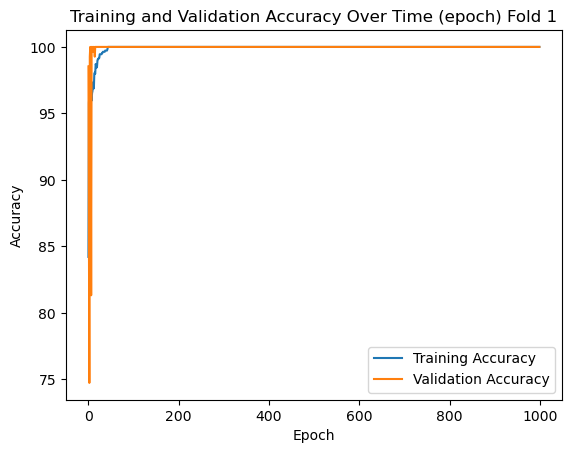

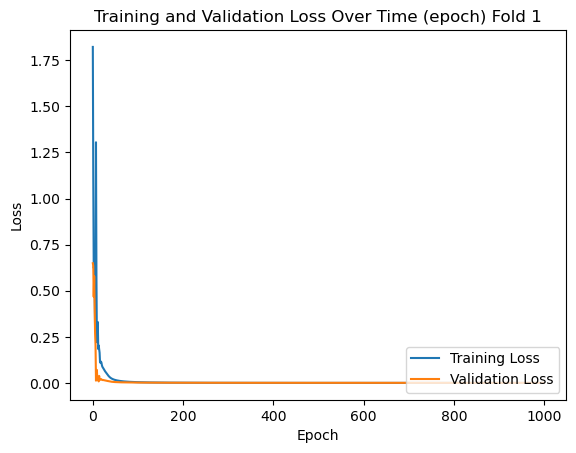

Exec Time : 171.94 seconds

---- Train Set ----
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 252
False Positive : 19
False Negative : 22
True Negative : 796

Class non-rumour Evaluation
- Precision : 92.989 %
- Recall : 91.971 %
- F1 : 0.92477

Class rumour Evaluation
- Precision : 97.311 %
- Recall : 97.669 %
- F1 : 0.97489

Combined Evaluation
- Accuracy : 96.235 %
- Precision : 95.15 %
- Recall : 94.82 %
- F1 : 0.94985
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Train, 96.235, 95.15, 94.82, 0.94985, 92.989, 91.971, 0.92477, 97.311, 97.669, 0.97489, 
Confusion Matrix Scikit-learn: 
[[796  19]
 [ 22 252]]


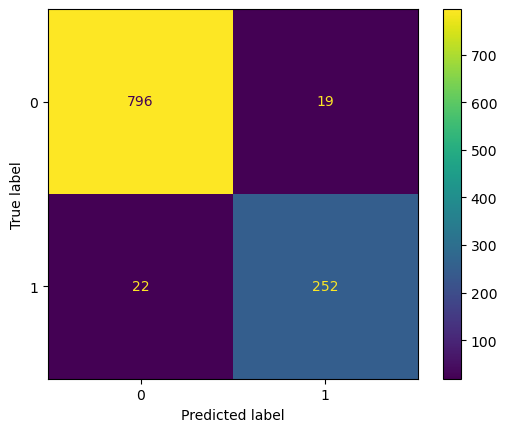


---- Validation Set ----
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


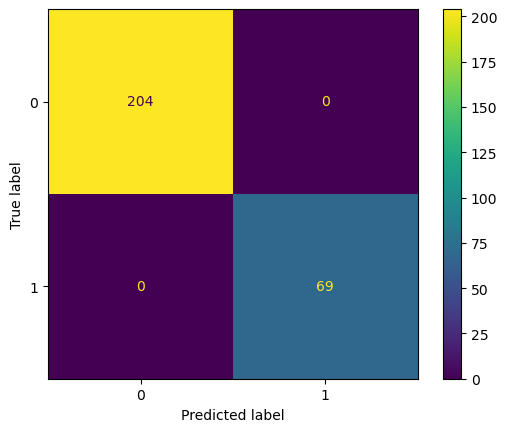


---- Test Set ----
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 24
False Positive : 8
False Negative : 7
True Negative : 89

Class non-rumour Evaluation
- Precision : 75.0 %
- Recall : 77.419 %
- F1 : 0.7619

Class rumour Evaluation
- Precision : 92.708 %
- Recall : 91.753 %
- F1 : 0.92228

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 83.854 %
- Recall : 84.586 %
- F1 : 0.84218
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Test, 88.281, 83.854, 84.586, 0.84218, 75.0, 77.419, 0.7619, 92.708, 91.753, 0.92228, 
128
128
Confusion Matrix Scikit-learn: 
[[89  8]
 [ 7 24]]


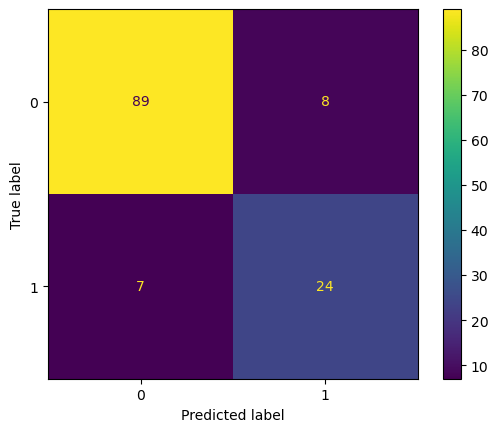

--- FOLD 2 ----
Multiclass Classification Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.012941258144564927, Validation Loss : 0.0051526580937206745
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0032568972383160144, Validation Loss : 0.002462605945765972
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0015033888630568981, Validation Loss : 0.0018220135243609548
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0008707563756615855, Validation Loss : 0.001517941476777196
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0005687968150596134, Validation Loss : 0.0013352727983146906
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00040042729233391583, Validation Loss : 0.0012083417968824506
--

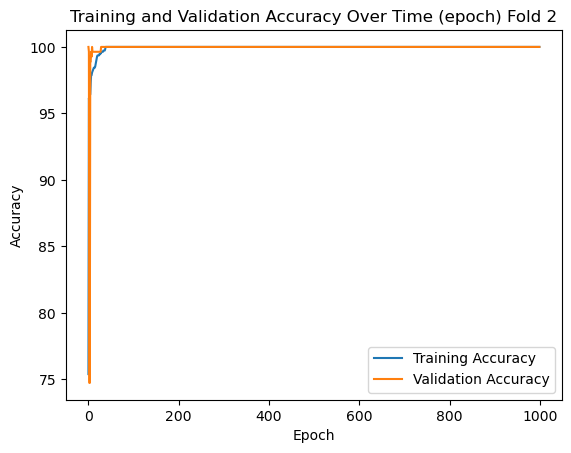

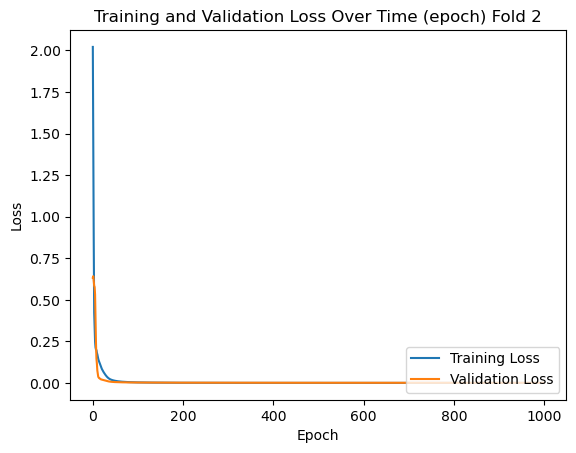

Exec Time : 156.26 seconds

---- Train Set ----
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 246
False Positive : 14
False Negative : 28
True Negative : 801

Class non-rumour Evaluation
- Precision : 94.615 %
- Recall : 89.781 %
- F1 : 0.92135

Class rumour Evaluation
- Precision : 96.622 %
- Recall : 98.282 %
- F1 : 0.97445

Combined Evaluation
- Accuracy : 96.143 %
- Precision : 95.619 %
- Recall : 94.032 %
- F1 : 0.94819
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Train, 96.143, 95.619, 94.032, 0.94819, 94.615, 89.781, 0.92135, 96.622, 98.282, 0.97445, 
Confusion Matrix Scikit-learn: 
[[801  14]
 [ 28 246]]


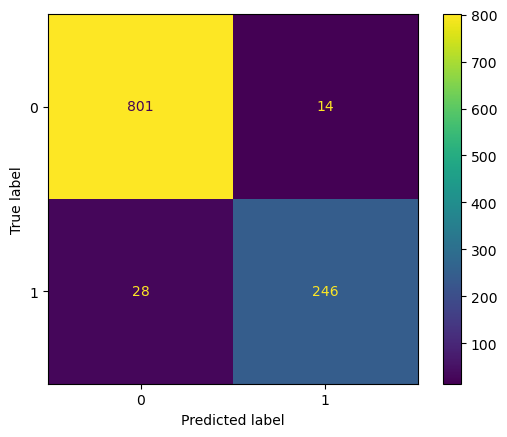


---- Validation Set ----
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


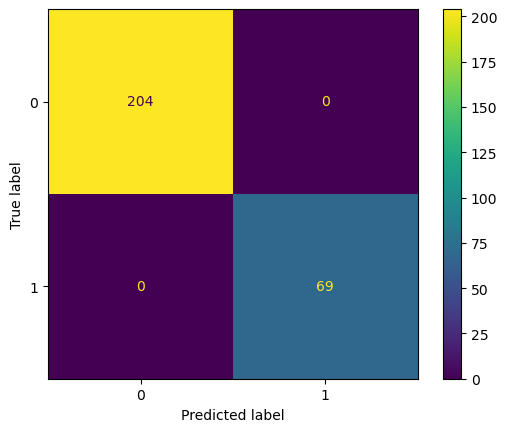


---- Test Set ----
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 23
False Positive : 6
False Negative : 8
True Negative : 91

Class non-rumour Evaluation
- Precision : 79.31 %
- Recall : 74.194 %
- F1 : 0.76667

Class rumour Evaluation
- Precision : 91.919 %
- Recall : 93.814 %
- F1 : 0.92857

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 85.615 %
- Recall : 84.004 %
- F1 : 0.84802
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Test, 89.062, 85.615, 84.004, 0.84802, 79.31, 74.194, 0.76667, 91.919, 93.814, 0.92857, 
128
128
Confusion Matrix Scikit-learn: 
[[91  6]
 [ 8 23]]


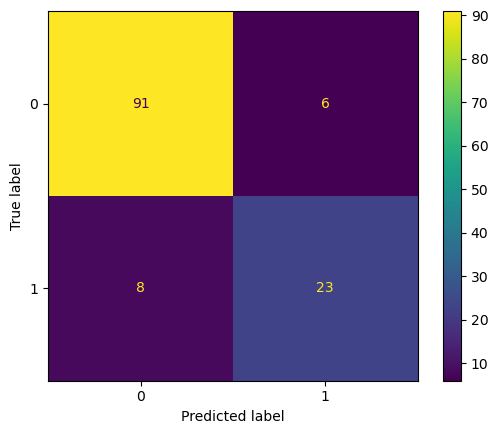

--- FOLD 3 ----
Multiclass Classification Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 0.011133683612570167, Validation Loss : 0.01011190377175808
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 0.002873665449442342, Validation Loss : 0.006063990760594606
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 0.0013405396020971239, Validation Loss : 0.00502750463783741
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 0.0007795449855620973, Validation Loss : 0.004545592702925205
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 0.0005102953109599184, Validation Loss : 0.004272002726793289
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 99.63235294117646, Train Loss : 

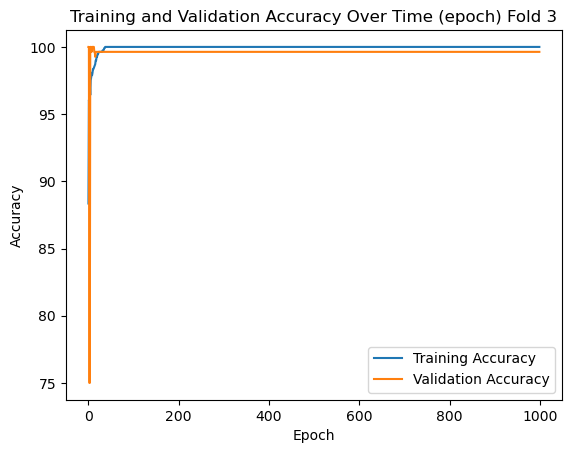

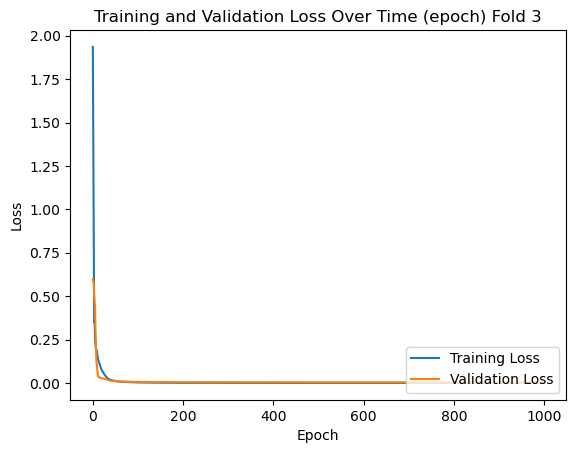

Exec Time : 157.49 seconds

---- Train Set ----
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 240
False Positive : 11
False Negative : 35
True Negative : 804

Class non-rumour Evaluation
- Precision : 95.618 %
- Recall : 87.273 %
- F1 : 0.91255

Class rumour Evaluation
- Precision : 95.828 %
- Recall : 98.65 %
- F1 : 0.97219

Combined Evaluation
- Accuracy : 95.78 %
- Precision : 95.723 %
- Recall : 92.962 %
- F1 : 0.94322
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Train, 95.78, 95.723, 92.962, 0.94322, 95.618, 87.273, 0.91255, 95.828, 98.65, 0.97219, 
Confusion Matrix Scikit-learn: 
[[804  11]
 [ 35 240]]


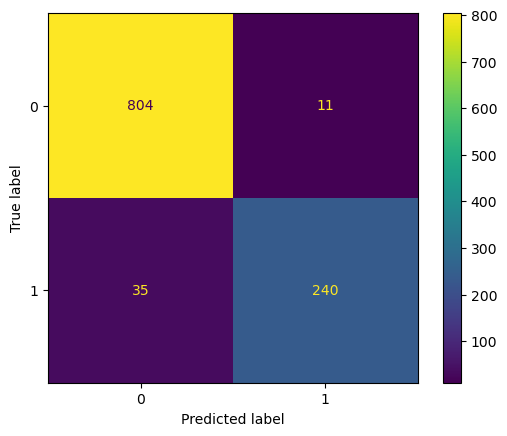


---- Validation Set ----
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 68
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  68]]


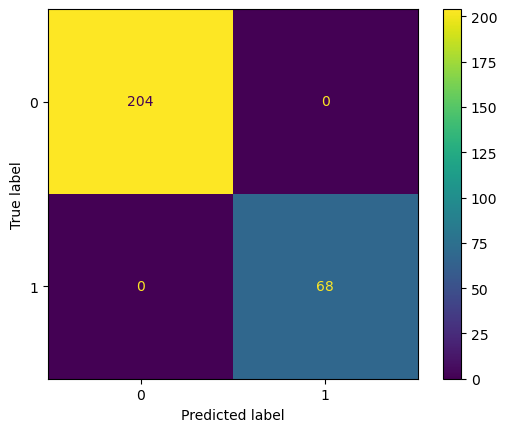


---- Test Set ----
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


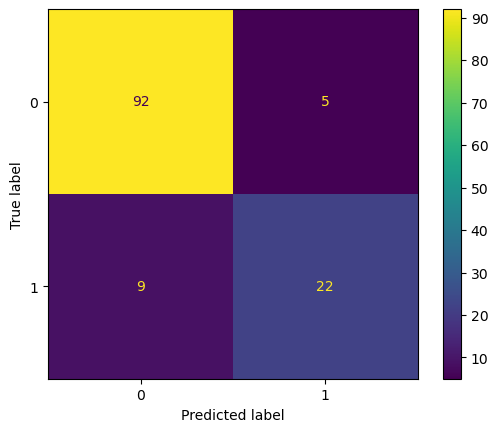

--- FOLD 4 ----
Multiclass Classification Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4
Using cuda
Saving after new best accuracy : 97.42647058823529
Saving after new best accuracy : 97.79411764705883
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 97.42647058823529, Train Loss : 0.016574255423620343, Validation Loss : 0.11601812392473221
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 97.42647058823529, Train Loss : 0.0038959680241532624, Validation Loss : 0.13721470534801483
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 97.42647058823529, Train Loss : 0.001773586409399286, Validation Loss : 0.14977313578128815
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 97.42647058823529, Train Loss : 0.0010216962400591, Validation Loss : 0.15876929461956024
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 97.42647058823529, Train Loss : 0.0006654506505583413, Validation Loss : 0.16591988503932953
-- Epoch 300, Train_Accuracy : 100.

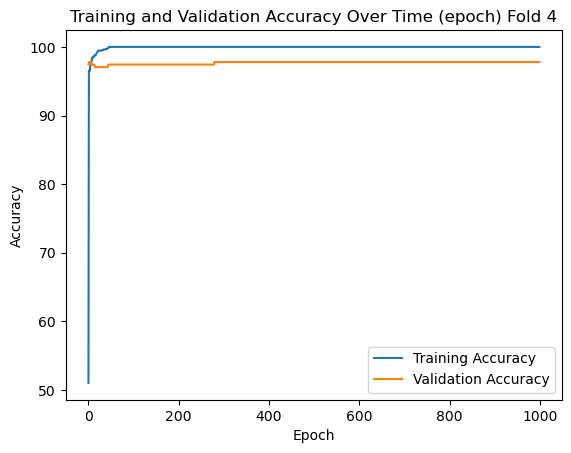

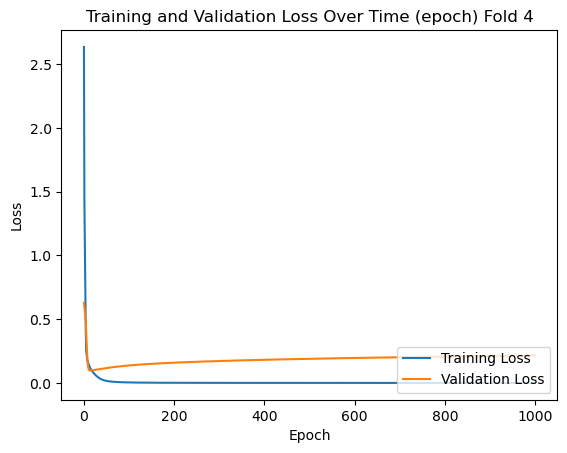

Exec Time : 156.45 seconds

---- Train Set ----
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 252
False Positive : 17
False Negative : 23
True Negative : 798

Class non-rumour Evaluation
- Precision : 93.68 %
- Recall : 91.636 %
- F1 : 0.92647

Class rumour Evaluation
- Precision : 97.199 %
- Recall : 97.914 %
- F1 : 0.97555

Combined Evaluation
- Accuracy : 96.33 %
- Precision : 95.439 %
- Recall : 94.775 %
- F1 : 0.95106
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Train, 96.33, 95.439, 94.775, 0.95106, 93.68, 91.636, 0.92647, 97.199, 97.914, 0.97555, 
Confusion Matrix Scikit-learn: 
[[798  17]
 [ 23 252]]


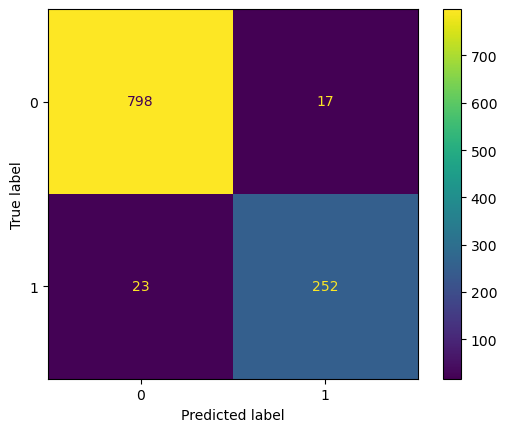


---- Validation Set ----
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 63
False Positive : 1
False Negative : 5
True Negative : 203

Class non-rumour Evaluation
- Precision : 98.438 %
- Recall : 92.647 %
- F1 : 0.95455

Class rumour Evaluation
- Precision : 97.596 %
- Recall : 99.51 %
- F1 : 0.98544

Combined Evaluation
- Accuracy : 97.794 %
- Precision : 98.017 %
- Recall : 96.078 %
- F1 : 0.97038
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Validation, 97.794, 98.017, 96.078, 0.97038, 98.438, 92.647, 0.95455, 97.596, 99.51, 0.98544, 
Confusion Matrix Scikit-learn: 
[[203   1]
 [  5  63]]


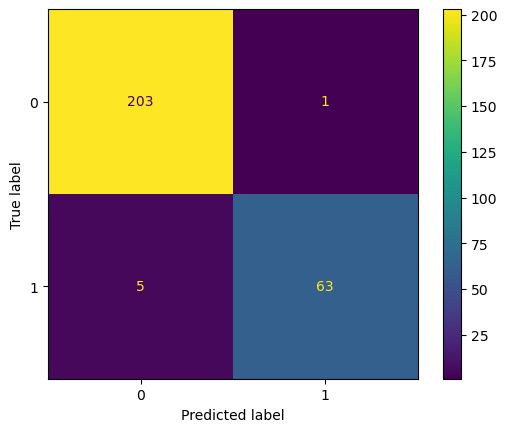


---- Test Set ----
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 23
False Positive : 7
False Negative : 8
True Negative : 90

Class non-rumour Evaluation
- Precision : 76.667 %
- Recall : 74.194 %
- F1 : 0.7541

Class rumour Evaluation
- Precision : 91.837 %
- Recall : 92.784 %
- F1 : 0.92308

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 84.252 %
- Recall : 83.489 %
- F1 : 0.83869
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Test, 88.281, 84.252, 83.489, 0.83869, 76.667, 74.194, 0.7541, 91.837, 92.784, 0.92308, 
128
128
Confusion Matrix Scikit-learn: 
[[90  7]
 [ 8 23]]


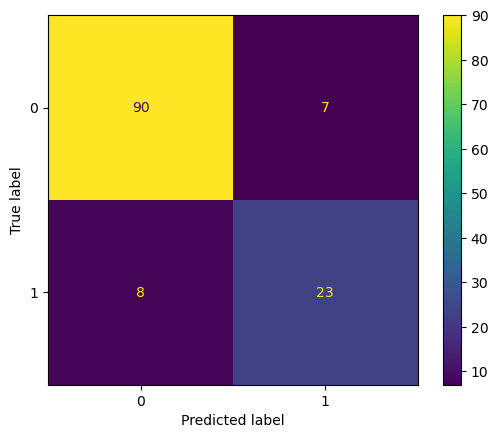

--- FOLD 5 ----
Multiclass Classification Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5
Using cuda
Saving after new best accuracy : 85.29411764705883
Saving after new best accuracy : 86.02941176470588
Saving after new best accuracy : 86.76470588235294
Saving after new best accuracy : 87.13235294117646
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train Loss : 0.001463533379137516, Validation Loss : 0.9049324989318848
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train Loss : 0.0005154108221177012, Validation Loss : 1.008422613143921
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train Loss : 0.00027040144414058886, Validation Loss : 1.075885534286499
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train Loss : 0.00016851416512508877, Validation Loss : 1.1261975765228271
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train L

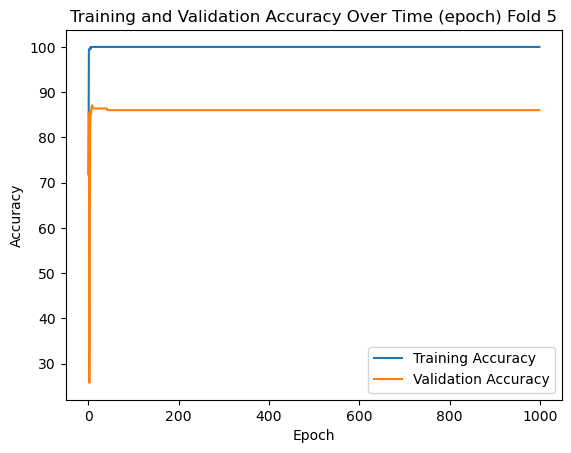

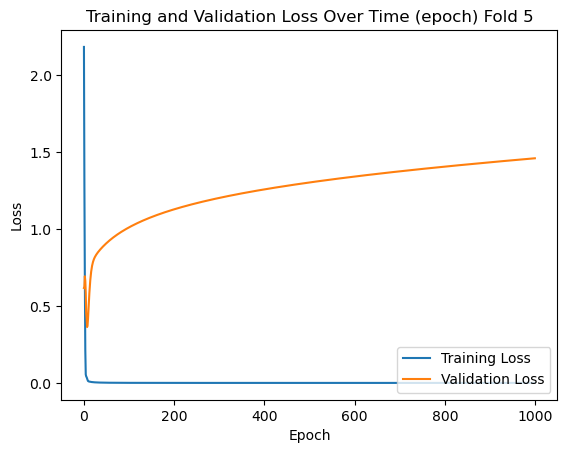

Exec Time : 156.78 seconds

---- Train Set ----
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 271
False Positive : 0
False Negative : 3
True Negative : 816

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 98.905 %
- F1 : 0.9945

Class rumour Evaluation
- Precision : 99.634 %
- Recall : 100.0 %
- F1 : 0.99817

Combined Evaluation
- Accuracy : 99.725 %
- Precision : 99.817 %
- Recall : 99.453 %
- F1 : 0.99635
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Train, 99.725, 99.817, 99.453, 0.99635, 100.0, 98.905, 0.9945, 99.634, 100.0, 0.99817, 
Confusion Matrix Scikit-learn: 
[[816   0]
 [  3 271]]


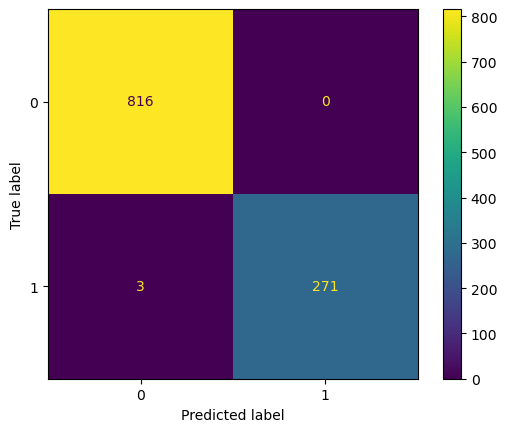


---- Validation Set ----
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 46
False Positive : 12
False Negative : 23
True Negative : 191

Class non-rumour Evaluation
- Precision : 79.31 %
- Recall : 66.667 %
- F1 : 0.72441

Class rumour Evaluation
- Precision : 89.252 %
- Recall : 94.089 %
- F1 : 0.91607

Combined Evaluation
- Accuracy : 87.132 %
- Precision : 84.281 %
- Recall : 80.378 %
- F1 : 0.82283
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Validation, 87.132, 84.281, 80.378, 0.82283, 79.31, 66.667, 0.72441, 89.252, 94.089, 0.91607, 
Confusion Matrix Scikit-learn: 
[[191  12]
 [ 23  46]]


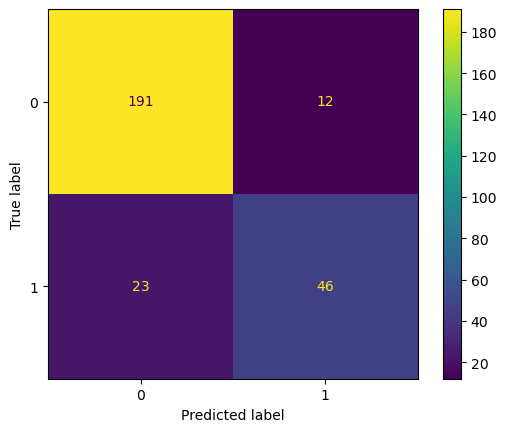


---- Test Set ----
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 7
False Negative : 9
True Negative : 90

Class non-rumour Evaluation
- Precision : 75.862 %
- Recall : 70.968 %
- F1 : 0.73333

Class rumour Evaluation
- Precision : 90.909 %
- Recall : 92.784 %
- F1 : 0.91837

Combined Evaluation
- Accuracy : 87.5 %
- Precision : 83.386 %
- Recall : 81.876 %
- F1 : 0.82624
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Test, 87.5, 83.386, 81.876, 0.82624, 75.862, 70.968, 0.73333, 90.909, 92.784, 0.91837, 
128
128
Confusion Matrix Scikit-learn: 
[[90  7]
 [ 9 22]]


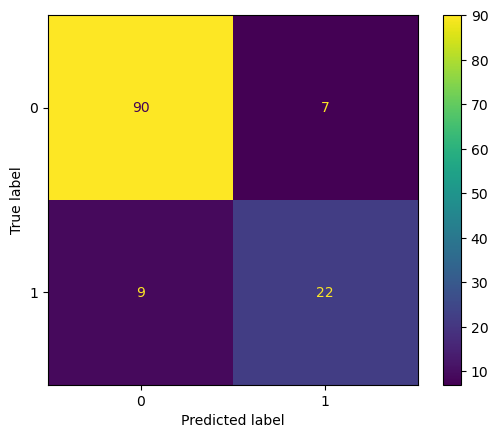

In [14]:
for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
    
    model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}_Fold{i+1}"
    start = time.time()
    print(f"Multiclass Classification {model_name}")
    model = ResNetClassifier(CNNResNet10(n_output=2), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
    model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\n---- Train Set ----")
    preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Validation Set ----")
    preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Test Set ----")
    preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

In [15]:
# model_name = f"{dataset_name}_ResNet18_CNN_{unique_name}"
# start = time.time()
# print(f"Multiclass Classification {model_name}")
# model = ResNetClassifier(CNNResNet18(n_output=4), train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# print("\n---- Train Set ----")
# preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(train_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Train"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(train_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Validation Set ----")
# preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(val_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Validation"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(val_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Test Set ----")
# preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(test_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Test"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(test_labels)
# predictions=np.array(preds)
# print(len(labels))
# print(len(predictions))
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()